In [1]:
#Importamos las librerías necesarias
import pandas as pd
import yaml
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
#Importamos el dataset desde el archivo yaml
with open ('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
#Leemos el dataset
df = pd.read_csv(config['data']['df'])

In [4]:
#Cambio nombre de columnas 
df = df.rename(columns={'satisfaction':'Satisfaction', 'Customer Type':'Customer_type', 'Type of Travel':'Type_of_travel', 'Flight Distance':'Flight_distance', 'Seat comfort':'Seat_comfort', 'Departure/Arrival time convenient':'Departure/Arrival_time', 'Food and drink':'Food_and_drink', 'Gate location':'Gate_location', 'Inflight wifi service':'Inflight_wifi_service', 'Inflight entertainment':'Inflight_entertaiment', 'Online support':'Online_support', 'Ease of Online booking':'Ease_of_online_booking', 'On-board service':'Onboard_service', 'Leg room service':'Leg_room_service', 'Baggage handling':'Baggage_handling', 'Checkin service':'Checkin_service', 'Online boarding': 'Online_boarding', 'Departure Delay in Minutes':'Departure_delay_in_minutes', 'Arrival Delay in Minutes':'Arrival_delay_in_minutes'})

In [5]:
#elimino las filas con los valores nulos en arrival delay minutes
df = df.dropna(subset=['Arrival_delay_in_minutes'])

EDA

In [6]:
#calculamos el porcentaje de clientes satifechos y insatisfechos
satisfied_percent = (df['Satisfaction'].value_counts(normalize=True)*100).reset_index()

satisfied_percent

,Satisfaction,proportion
0,satisfied,54.74063
1,dissatisfied,45.25937


In [7]:
#creamos el gráfico circular para ver la distribución de clientes satisfechos y insatisfechos
fig = px.pie(satisfied_percent, values='proportion', names='Satisfaction', title='Distribution of satisfied and dissatisfied customers')
fig.show()

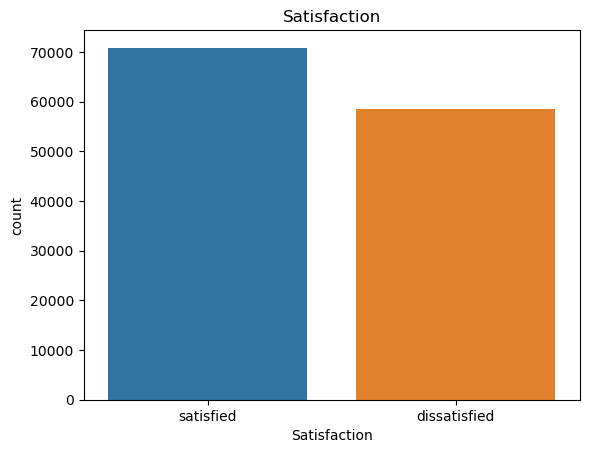

In [8]:
# Satisfaction 
sns.countplot(x='Satisfaction', data=df)
plt.title('Satisfaction')
plt.show()

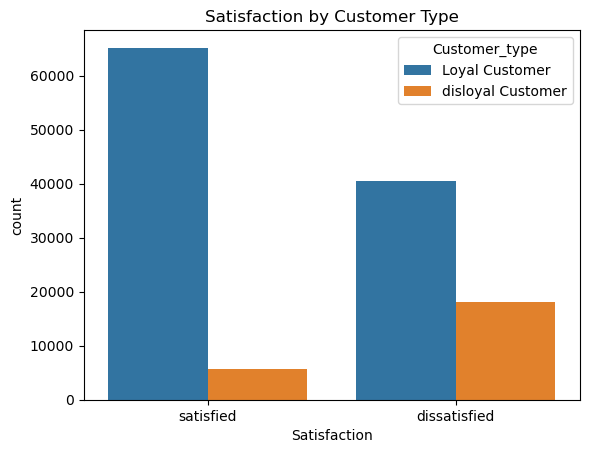

In [9]:
# Satisfaction by customer type
sns.countplot(x='Satisfaction', hue='Customer_type', data=df)
plt.title('Satisfaction by Customer Type')
plt.show()

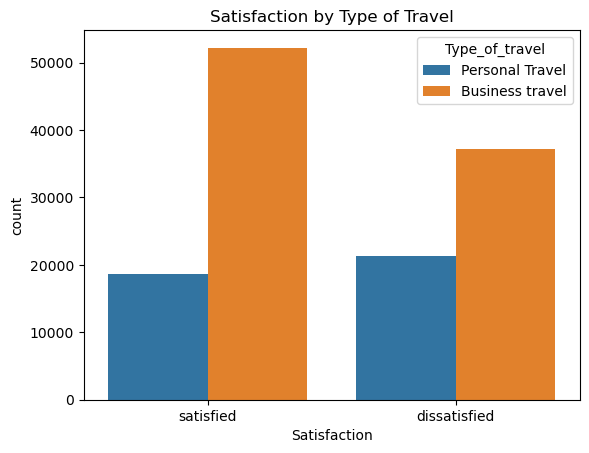

In [10]:
# Satisfaction by type of travel
sns.countplot(x='Satisfaction', hue='Type_of_travel', data=df)
plt.title('Satisfaction by Type of Travel')
plt.show()

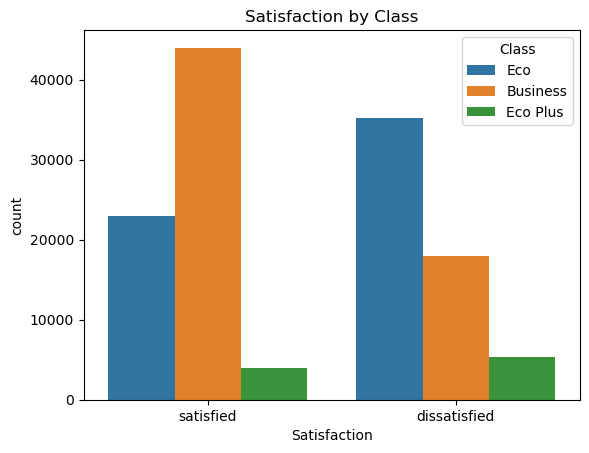

In [11]:
# Satisfaction by Class
sns.countplot(x='Satisfaction', hue='Class', data=df)
plt.title('Satisfaction by Class')
plt.show()

/opt/anaconda3/envs/airline_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



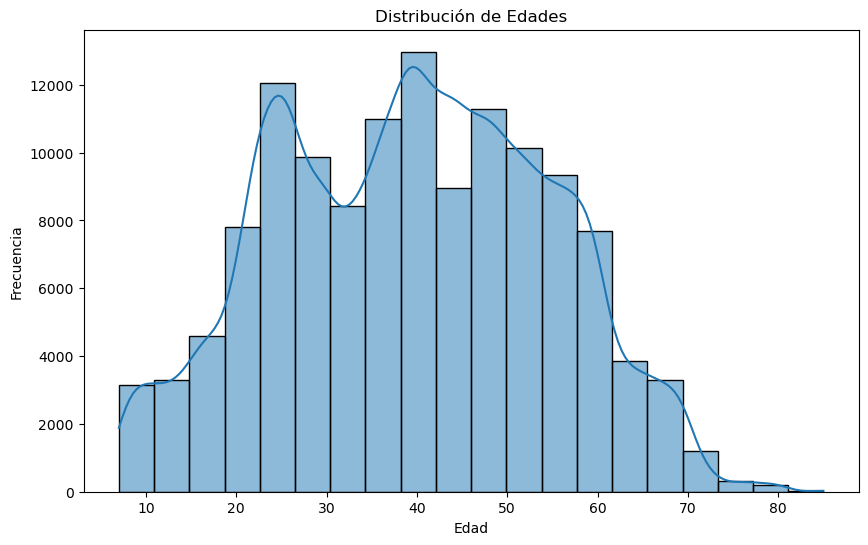

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

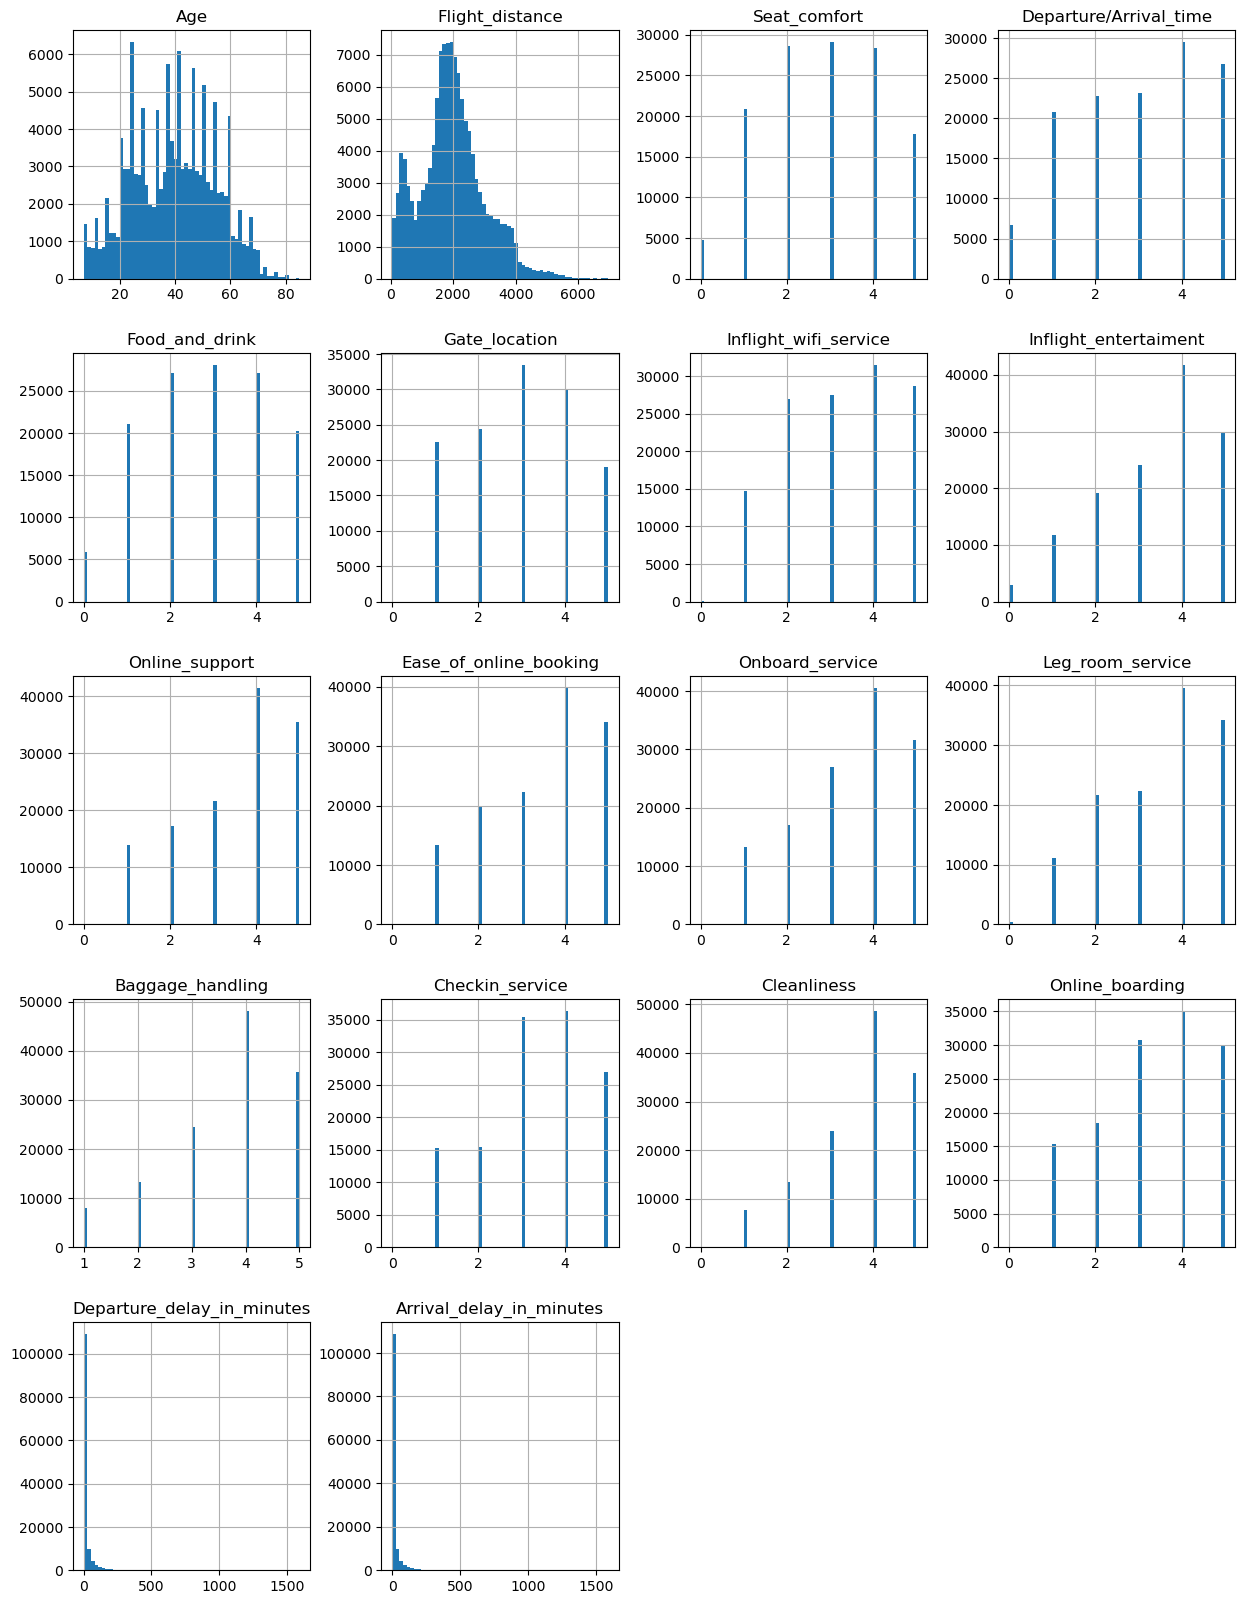

In [13]:
#comprobamos la distribución de todas las variables numéricas
numeric_var = ['Age', 'Flight_distance', 'Seat_comfort', 'Departure/Arrival_time', 'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertaiment', 'Online_support', 'Ease_of_online_booking', 'Onboard_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_delay_in_minutes', 'Arrival_delay_in_minutes']

ax = df.hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10)
for axis in ax.flatten():
    axis.ticklabel_format(style='plain', axis='x')

plt.show()

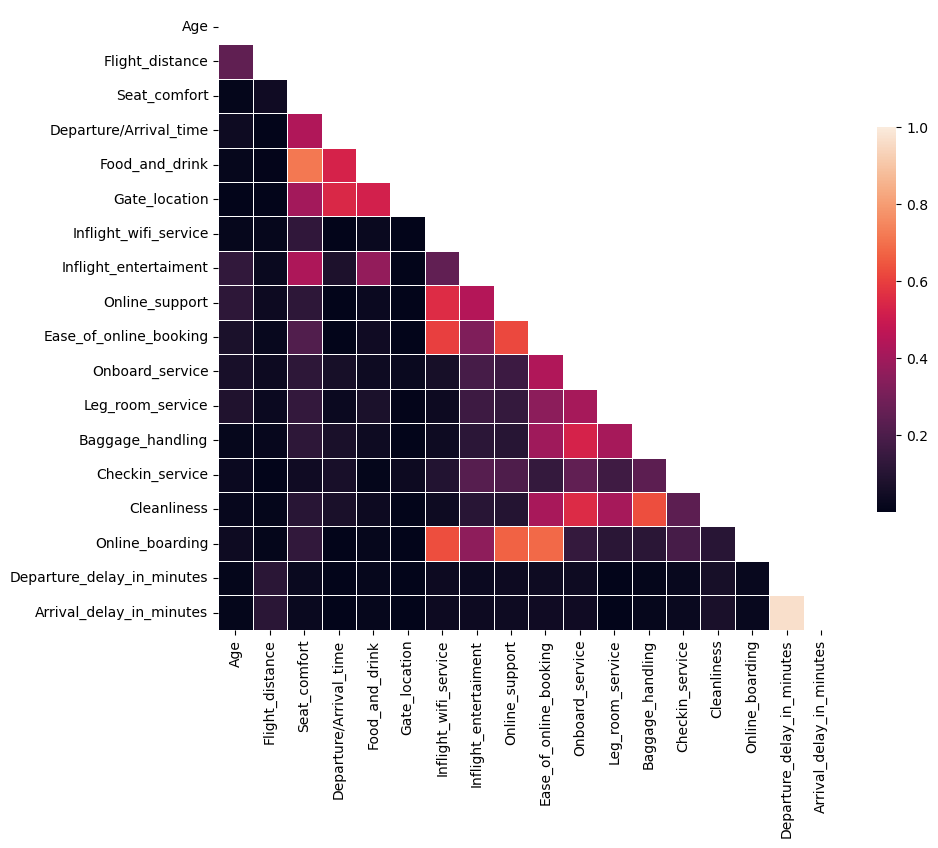

In [14]:
#Calculamos la matriz de correlación
corr=np.abs(df[numeric_var].corr())

#Creamos la máscara para la representación triangular
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True


#Configuramos el gráfico de matplotlib
f, ax = plt.subplots(figsize=(10, 10))

#Generamos un mapa de colores personalizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Dibujamos el heatmap con la máscara y la relación de aspecto correcta
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr)

plt.show()

In [15]:
#calculamos el chi cuadrado para cuantificar la relación entre las variables categóricas
categoric_var = ['Customer_type', 'Class','Type_of_travel', 'Satisfaction']

results = {}
for col1 in df[categoric_var]:
    for col2 in df[categoric_var]:
        if col1 != col2:
            contingency_table = pd.crosstab(df[categoric_var][col1], df[categoric_var][col2])
            chi2, p, dof, ex = chi2_contingency(contingency_table)
            results[(col1, col2)] = {'chi2': chi2, 'p': p}

In [16]:
#organizamos los datos en una matriz cuadrada
chi_squared_matrix = pd.DataFrame.from_dict(results, orient='index').reset_index()

/opt/anaconda3/envs/airline_project/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



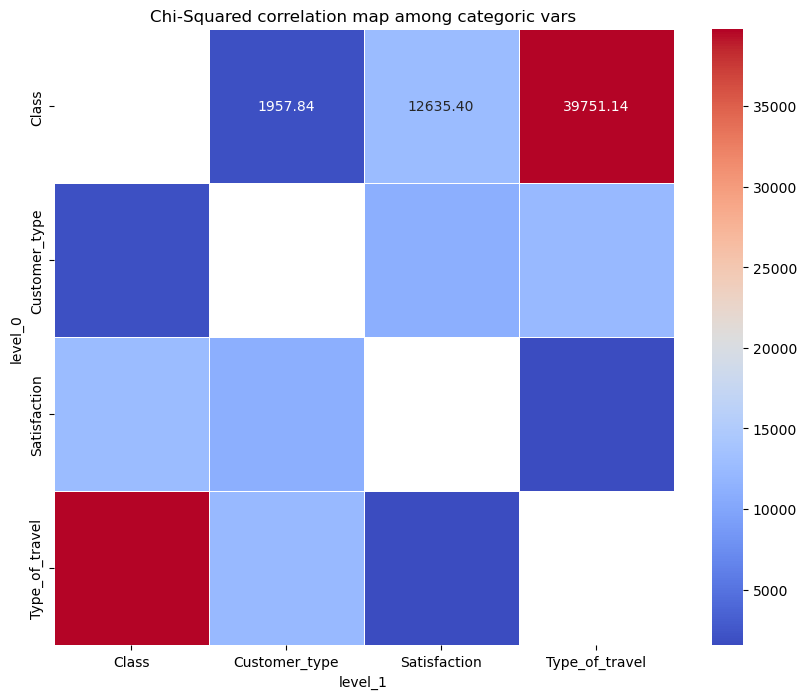

In [17]:
#creamos un mapa de calor con seaborn
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(chi_squared_matrix.pivot(index='level_0', columns='level_1', values='chi2'),
                      annot=True,
                      cmap='coolwarm',
                      linewidths=0.5,
                      fmt=".2f")
heatmap.set_title('Chi-Squared correlation map among categoric vars')
plt.show()

PREDICTION MODEL

In [18]:
#Transformo la columna Satisfaction a tipo numérico para la predicción logarítmica
df['Satisfaction'] = df['Satisfaction'].map({'dissatisfied': 0, 'satisfied': 1})

In [19]:
df_dummies = pd.get_dummies(df, columns = ['Class', 'Customer_type', 'Type_of_travel'])

Train Test Split

In [20]:
#Seleccionamos las variables que emplearemos en el algoritmo y definimos nuestro target en 'Satisfaction'
features = df_dummies[['Seat_comfort', 'Departure/Arrival_time', 'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertaiment', 'Online_support', 'Ease_of_online_booking', 'Onboard_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_delay_in_minutes', 'Arrival_delay_in_minutes']]
target = df_dummies['Satisfaction']

In [21]:
#Dividimos los datos en conjuntos de entrenamiento y prueba, donde el 20% de los datos se utiliza para la prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

Best Model: Gradient Boost

In [22]:
#probamos con el modelo Gradient Boost
gb= GradientBoostingClassifier(max_depth=20,
                                   n_estimators=2000)

In [23]:
#entrenamos el modelo
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=20, n_estimators=2000)

In [24]:
pred = gb.predict(X_test)

precision_gradient_boost  = precision_score(y_test, pred, average='macro')
recall_gradient_boost  = recall_score(y_test, pred, average='macro') 
f1_gradient_boost  = f1_score(y_test, pred, average='macro')

print('Precision:',precision_gradient_boost)
print('Recall:',recall_gradient_boost)
print('F1:',f1_gradient_boost)

Precision: 0.9417148051088655
Recall: 0.9426654982100853
F1: 0.9421560551072732


Despues de probar todos los modelos (en el documento main), el que tiene mejores resultados es el Gradient Boost

In [25]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred)
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
class_names = y_train.unique()

In [27]:
import plotly.graph_objects as go
# Creating a confusion matrix heatmap using Plotly Graph Objects with true class names
fig = go.Figure(data=go.Heatmap(
                   z=conf_matrix,
                   x=class_names,
                   y=class_names,
                   colorscale='Blues'))

# Adding annotations
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        fig.add_annotation(
            x=j, y=i,
            text=str(conf_matrix[i][j]),
            showarrow=False,
            font=dict(color="black", size=12)
        )

# Updating layout for better readability
fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=800, height=800
)

fig.show()

Featuring Importance

In [28]:
feature_names = X_train.columns

In [29]:
feature_importances = gb.feature_importances_

In [30]:
indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[indices]
sorted_features = [feature_names[i] for i in indices]

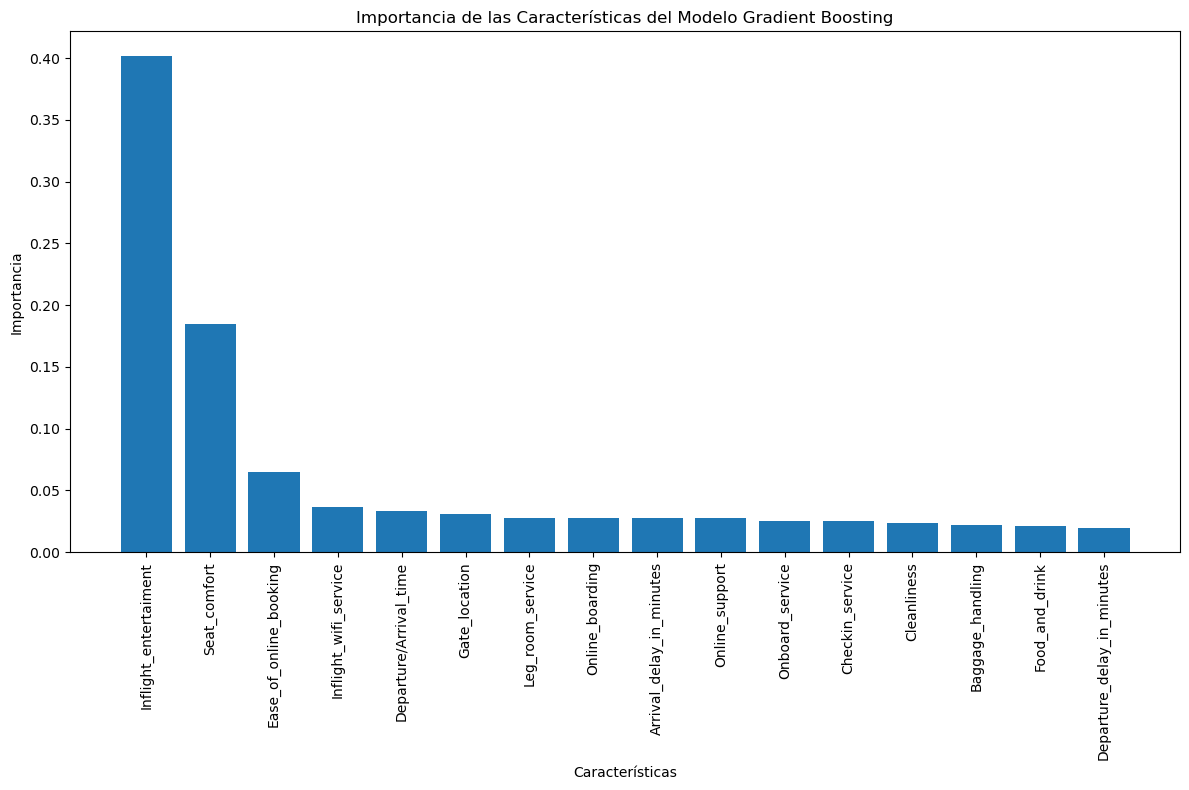

In [31]:
plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características del Modelo Gradient Boosting")
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.tight_layout()  # Ajusta automáticamente los subplots para que quepan en el área de la figura
plt.show()

In [32]:
fig = px.bar(
    x=sorted_features, 
    y=sorted_importances, 
    labels={'x': 'Características', 'y': 'Importancia'},
    title="Importancia de las Características del Modelo Gradient Boosting"
)
fig.show()

Production

In [33]:
#probamos con el modelo Gradient Boost
gb= GradientBoostingClassifier(max_depth=20,
                                   n_estimators=2000)

In [34]:
#entrenamos el modelo
gb.fit(features, target)

GradientBoostingClassifier(max_depth=20, n_estimators=2000)

In [56]:
gb

GradientBoostingClassifier(max_depth=20, n_estimators=2000)

In [59]:
import joblib

joblib.dump(gb, 'modelo_gb.pkl')

['modelo_gb.pkl']

Input for Prediction

In [35]:
features

,Seat_comfort,Departure/Arrival_time,Food_and_drink,Gate_location,Inflight_wifi_service,Inflight_entertaiment,Online_support,Ease_of_online_booking,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_delay_in_minutes,Arrival_delay_in_minutes
0,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,5,5,5,3,2,5,2,2,3,3,4,4,4,2,0,0.0
129876,2,3,2,4,2,1,1,3,2,3,3,1,2,1,174,172.0
129877,3,0,3,3,3,2,2,4,4,3,4,2,3,2,155,163.0
129878,3,2,3,2,3,2,2,3,3,2,3,2,1,2,193,205.0


In [36]:
df_to_predict = pd.DataFrame(columns=features.columns)

In [60]:
number_seats = 100

In [62]:
percent_of_high_comfort = 0.3 #5 y 4

percent_of_low_comfort = 1 - percent_of_high_comfort #3 y 2

Seat_comfort_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_of_low_comfort)))

Seat_comfort_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_of_high_comfort)))

df_to_predict['Seat_comfort'] = Seat_comfort_temp_1 + Seat_comfort_temp_3

In [38]:
Departure_options = features['Departure/Arrival_time'].unique()
df_to_predict['Departure/Arrival_time'] = np.random.choice(Departure_options, size=number_seats)

In [39]:
percent_of_high_food_payment = 0.3 #5 y 4

percent_of_medium_food_free = 1 - percent_of_high_food_payment #3 y 2

Food_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_of_medium_food_free)))

Food_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_of_high_food_payment)))

df_to_predict['Food_and_drink'] = Food_temp_1 + Food_temp_3

In [40]:
Gate_location = 1  #1 y 0: 1 es facil acceso y 0 no acceso puerta

Gate_location_temp_1 = list(np.random.choice([5,4], size=int(number_seats*Gate_location)))

Gate_location_temp_3 = list(np.random.choice([1,0], size=int(number_seats*(1-Gate_location))))

df_to_predict['Gate_location'] = Gate_location_temp_1 + Gate_location_temp_3

In [41]:
percent_of_high_wifi_payment = 0.3 #5 y 4

percent_of_medium_wifi_free = 1 - percent_of_high_wifi_payment #3 y 2

Wifi_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_of_medium_wifi_free)))

Wifi_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_of_high_wifi_payment)))

df_to_predict['Inflight_wifi_service'] = Wifi_temp_1 + Wifi_temp_3

In [42]:
percent_of_high_entertaiment_payment = 0.3 #5 y 4

percent_of_medium_entertaiment_free = 1 - percent_of_high_entertaiment_payment #3 y 2

Entertaiment_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_of_medium_entertaiment_free)))

Entertaiment_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_of_high_entertaiment_payment)))

df_to_predict['Inflight_entertaiment'] = Entertaiment_temp_1 + Entertaiment_temp_3

In [43]:
online_support = 1  #1 y 0: 1 es posibilidad de online booking y 0 no posibilidad

online_support_temp_1 = list(np.random.choice([5,4], size=int(number_seats*online_support)))

online_support_temp_3 = list(np.random.choice([1,0], size=int(number_seats*(1-online_support))))

df_to_predict['Online_support'] = online_support_temp_1 + online_support_temp_3

In [44]:
ease_booking_online = 1  #1 y 0: 1 es posibilidad de online booking y 0 no posibilidad

ease_booking_online_temp_1 = list(np.random.choice([5,4], size=int(number_seats*ease_booking_online)))

ease_booking_online_temp_3 = list(np.random.choice([1,0], size=int(number_seats*(1-ease_booking_online))))

df_to_predict['Ease_of_online_booking'] = ease_booking_online_temp_1 + ease_booking_online_temp_3

In [45]:
onboard_service = 1  #1 y 0: 1 es posibilidad de online booking y 0 no posibilidad

onboard_service_temp_1 = list(np.random.choice([5,4], size=int(number_seats*onboard_service)))

onboard_service_temp_3 = list(np.random.choice([1,0], size=int(number_seats*(1-onboard_service))))

df_to_predict['Onboard_service'] = onboard_service_temp_1 + onboard_service_temp_3

In [ ]:
percent_of_high_leg_room_service = 0.3 #5 y 4

percent_of_medium_leg_room_service = 1 - percent_of_high_leg_room_service #3 y 2

Leg_room_service_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_of_medium_leg_room_service)))

Leg_room_service_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_of_high_leg_room_service)))

df_to_predict['Leg_room_service'] = Leg_room_service_temp_1 + Leg_room_service_temp_3

In [47]:
percent_of_high_baggage_payment = 0.3 #5 y 4

percent_of_medium_baggage_free = 1 - percent_of_high_baggage_payment #3 y 2

Baggage_handling_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_of_medium_baggage_free)))

Baggage_handling_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_of_high_baggage_payment)))

df_to_predict['Baggage_handling'] = Baggage_handling_temp_1 + Baggage_handling_temp_3

In [48]:
checkin_service = 1  #1 y 0: 1 es posibilidad de online booking y 0 no posibilidad

Checkin_service_temp_1 = list(np.random.choice([5,4], size=int(number_seats*checkin_service)))

Checkin_service_temp_3 = list(np.random.choice([1,0], size=int(number_seats*(1-checkin_service))))

df_to_predict['Checkin_service'] = Checkin_service_temp_1 + Checkin_service_temp_3

In [49]:
number_clean_sesion_per_10_trip = 6 #5 y 4

percent_clean_trip = number_clean_sesion_per_10_trip/10

percent_dirty_trip = (10 - number_clean_sesion_per_10_trip)/10

Cleanliness_temp_1 = list(np.random.choice([5,4], size=int(number_seats*percent_clean_trip)))

Cleanliness_temp_3 = list(np.random.choice([1,0], size=int(number_seats*percent_dirty_trip)))

df_to_predict['Cleanliness'] = Cleanliness_temp_1 + Cleanliness_temp_3

In [50]:
online_boarding = 1  #1 y 0: 1 es posibilidad de online booking y 0 no posibilidad

Online_boarding_temp_1 = list(np.random.choice([5,4], size=int(number_seats*online_boarding)))

Online_boarding_temp_3 = list(np.random.choice([1,0], size=int(number_seats*(1-online_boarding))))

df_to_predict['Online_boarding'] = Online_boarding_temp_1 + Online_boarding_temp_3

In [51]:
Departure_delay_in_minutes_options = features.Departure_delay_in_minutes.unique()
df_to_predict['Departure_delay_in_minutes'] = np.random.choice(Departure_delay_in_minutes_options, size=number_seats)

In [52]:
Arrival_delay_in_minutes_options = features.Arrival_delay_in_minutes.unique()
df_to_predict['Arrival_delay_in_minutes'] = np.random.choice(Arrival_delay_in_minutes_options, size=number_seats)

In [53]:
df_to_predict

,Seat_comfort,Departure/Arrival_time,Food_and_drink,Gate_location,Inflight_wifi_service,Inflight_entertaiment,Online_support,Ease_of_online_booking,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_delay_in_minutes,Arrival_delay_in_minutes
0,4,0,5,4,5,4,4,4,4,5,5,5,5,4,197,96.0
1,5,4,5,4,5,5,4,4,5,4,5,4,4,5,183,448.0
2,5,4,4,5,5,5,5,5,5,4,5,4,5,5,366,305.0
3,5,1,4,5,4,4,5,5,5,4,4,5,5,4,978,334.0
4,5,2,4,5,5,5,5,5,5,5,4,5,5,4,49,274.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,4,0,4,1,1,5,4,5,0,1,5,0,4,416,420.0
96,1,4,0,5,0,1,5,4,5,1,0,5,1,4,217,336.0
97,1,1,1,4,1,0,5,4,5,1,1,5,0,4,122,4.0
98,0,3,1,4,0,1,4,5,4,0,0,4,1,4,394,455.0


In [54]:
predict = gb.predict(df_to_predict)

In [85]:
df_predict = pd.DataFrame(predict).value_counts(normalize=True)

In [90]:
df_predict_proportion = df_predict.reset_index().rename(columns={0:'Satisfaction_binari'})

In [96]:
df_predict_proportion['Satisfaction_binari'] = df_predict_proportion['Satisfaction_binari'].astype(str).replace({'0':'No', '1':'Yes'})

In [98]:
fig = px.pie(df_predict_proportion, values='proportion', names='Satisfaction_binari', title='Distribution of Satisfied and Dissatisfied Customers')
fig.show()